In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import xarray as xr

from scipy import stats
from scipy import integrate
from numpy import exp
import math

from osgeo import gdal
#from gistool import rasterize
import pyhdf
from pyhdf.SD import SD
import geopandas as gpd
import rasterio
import rioxarray as rxr

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors
plt.rcParams['font.family'] = 'Arial'

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader

import shap
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from matplotlib import font_manager
font_path = "/portal1/dell/li-b/font/ARIAL.TTF"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
# print(prop.get_name())  # 显示当前使用字体的名称

# 字体设置
plt.rcParams['font.family'] = 'ARIAL' # 使用字体中的无衬线体
# plt.rcParams['font.sans-serif'] = prop.get_name()  # 根据名称设置字体
# plt.rcParams['font.size'] = 10 # 设置字体大小
# plt.rcParams['axes.unicode_minus'] = False # 使坐标轴刻度标签正常显示正负号

In [3]:
# inpath = 'C:/Users/bn_li/Desktop/manu1/data/'
inpath = '/portal1/dell/li-b/manu1/data/'
# outpath = 'D:/figs_manu1/'
outpath = '/portal1/dell/li-b/manu1/figs/'

## pre

In [8]:
mask = xr.open_dataset(inpath+'lc.nc')
mask1 = xr.open_dataset(inpath+'spi_mask.nc')

def varimask_forest(ds):

    x = ds.dims['lon']
    y = ds.dims['lat']
    
    mask_a = mask['vari'].values == 1
    mask_b = mask1['vari'].values <= 0
    combined_mask = mask_a & mask_b  # Logical AND
    
    ratio = np.sum(combined_mask) / np.sum(mask_a) * 100
    print(f"Forest mask ratio: {ratio:.2f}%")
    
    anos = np.full_like(ds['vari'].values, np.nan)
    for t in range(ds.dims['time']):    #### change the time length
        vari_t = ds['vari'][t,:,:].values
        vari_masked = np.where(combined_mask, vari_t, np.nan)
        arr = vari_masked.copy() #### exclude sichuan mountaions 
        arr[:80,:51] = np.nan
        anos[t,:,:] = arr
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
    return(ds_ex)

def varimask_shrub(ds):

    x = ds.dims['lon']
    y = ds.dims['lat']
    
    mask_a = mask['vari'].values == 2
    mask_b = mask1['vari'].values <= 0
    combined_mask = mask_a & mask_b  # Logical AND
    
    ratio = np.sum(combined_mask) / np.sum(mask_a) * 100
    print(f"Shrubland mask ratio: {ratio:.2f}%")
    
    anos = np.full_like(ds['vari'].values, np.nan)
    for t in range(ds.dims['time']):    #### change the time length
        vari_t = ds['vari'][t,:,:].values
        vari_masked = np.where(combined_mask, vari_t, np.nan)
        anos[t,:,:] = vari_masked
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
    return(ds_ex)


def varimask_crop(ds):

    x = ds.dims['lon']
    y = ds.dims['lat']
    
    mask_a = mask['vari'].values == 5
    mask_b = mask1['vari'].values <= 0
    combined_mask = mask_a & mask_b  # Logical AND
    
    ratio = np.sum(combined_mask) / np.sum(mask_a) * 100
    print(f"Crop mask ratio: {ratio:.2f}%")
    
    anos = np.full_like(ds['vari'].values, np.nan)
    for t in range(ds.dims['time']):    #### change the time length
        vari_t = ds['vari'][t,:,:].values
        vari_masked = np.where(combined_mask, vari_t, np.nan)
        anos[t,:,:] = vari_masked
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
    return(ds_ex)

In [9]:
def moving_window_mean(da, size=3):
    """
    Compute spatial moving window mean for each pixel.
    da: xarray.DataArray with dims (time, lat, lon)
    size: window size (odd number, e.g., 3)
    """
    return da.rolling(lat=size, lon=size, center=True).mean()

## drought legacy

In [6]:
ds = xr.open_dataset(inpath+'shapley/lai_new_qc_0.05_1d.nc').sel(time=slice('2001-01-01','2023-12-31'))
y3 = xr.open_dataset(inpath+'shapley/ndvi_new_qc_0.05_1d.nc').sel(time=slice('2001-01-01','2023-12-31'))

last_date = ds.time.values[-1]
new_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), end="2023-12-31")
last_slice = ds.sel(time=last_date)
new_data = last_slice.expand_dims(time=new_dates)
y1 = xr.concat([ds, new_data], dim='time')

In [7]:
ds1 = varimask_forest(y1)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2023-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat1 = y_list.reshape((365, -1), order='F')

ds1 = varimask_forest(y3)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2023-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat2 = y_list.reshape((365, -1), order='F')

C:\Users\bn_li\AppData\Local\Temp\ipykernel_1684\3176914554.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_1684\3176914554.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  y = ds.dims['lat']


Forest mask ratio: 84.22%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_1684\3176914554.py:17: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):    #### change the time length
C:\Users\bn_li\AppData\Local\Temp\ipykernel_1684\3176914554.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_1684\3176914554.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, plea

Forest mask ratio: 84.22%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_1684\3176914554.py:17: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):    #### change the time length


C:\Users\bn_li\AppData\Local\Temp\ipykernel_1684\459925142.py:17: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(182, 274, color='lightgray', alpha=0.2, edgecolor='none', linewidth=0)


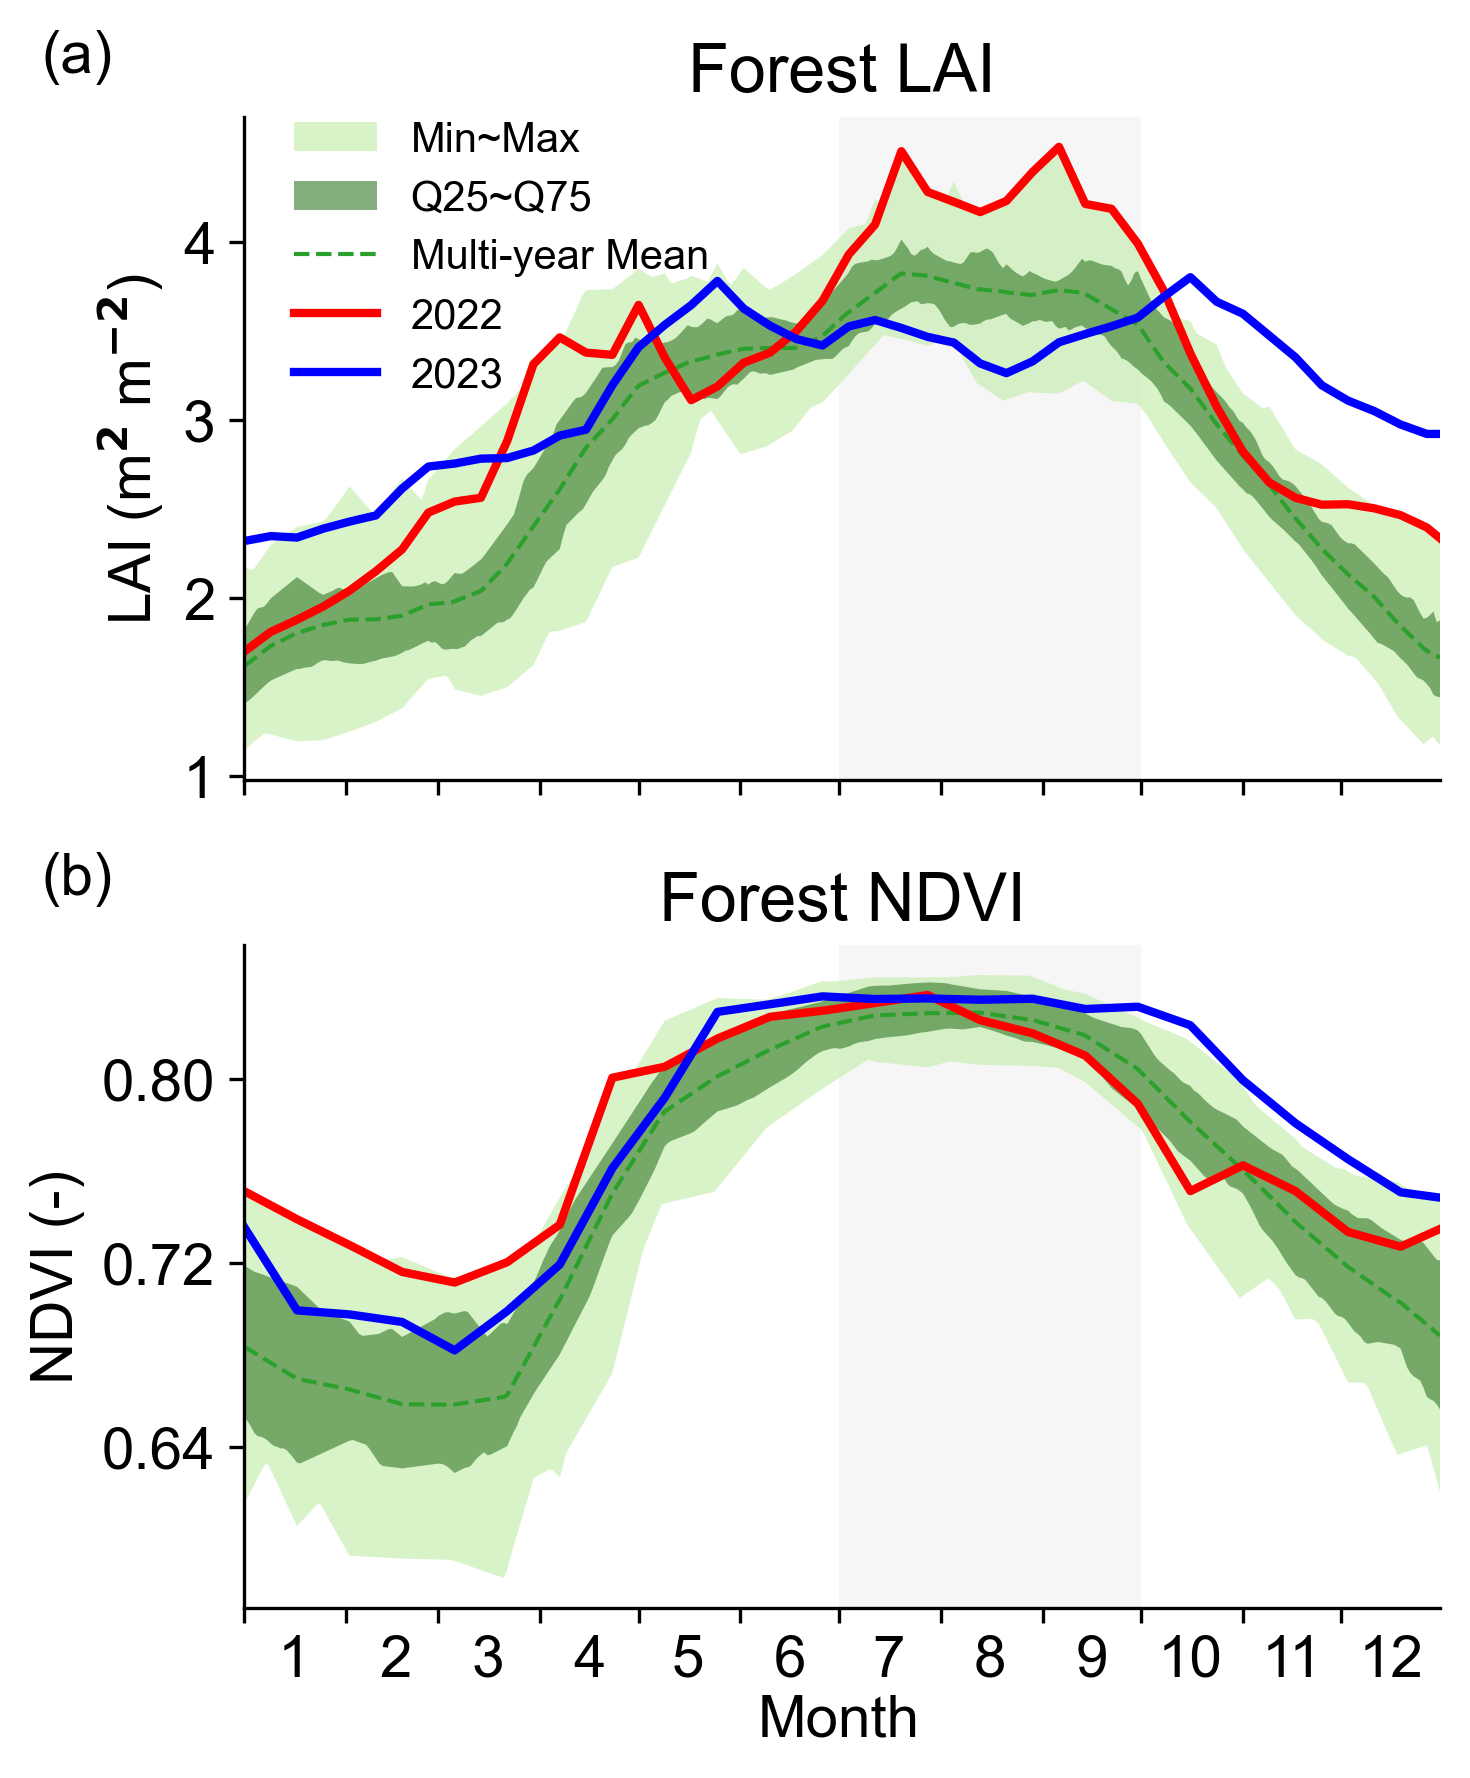

In [8]:
from matplotlib.ticker import MaxNLocator
fig, axes = plt.subplots(2,1,dpi = 300, figsize=(5,6))
date = np.arange(1,366)
date1 = np.arange(1,366)
axes_flat = axes.flatten()
data = [y_mat1, y_mat2]
title = ["Forest LAI","Forest NDVI"]
ylabel = ['LAI (m$\mathbf{^{2}}$ m$\mathbf{^{-2}}$)','NDVI (-)']
# means = [3.77, 3.77, 3.60, 3.38]
# abnorms = [3.77+0.33, 3.77+0.47, 3.60+0.58, 3.38+0.64]
for i, ax in enumerate(axes_flat):
    if i < len(data):  # Ensure we don't exceed the number of data arrays
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.axvline(x=182, color='dimgrey', linestyle='--', lw=0.8)
        # ax.axvline(x=274, color='dimgrey', linestyle='--', lw=0.8)
        ax.axvspan(182, 274, color='lightgray', alpha=0.2, edgecolor='none', linewidth=0)
        ax.fill_between(date, np.nanpercentile(data[i][:,:-1],q=0,axis=1),np.nanpercentile(data[i][:,:-1],q=100,axis=1), color='#C0EBA6',alpha=0.6,label='Min~Max',edgecolor='none')
        ax.fill_between(date, np.nanpercentile(data[i][:,:-1],q=25,axis=1),np.nanpercentile(data[i][:,:-1],q=75,axis=1), color='#347928',alpha=0.6,label='Q25~Q75',edgecolor='none')
        ax.plot(date,np.nanmean(data[i][:,:-1],axis=1),lw=1,ls='--',color='tab:green', label='Multi-year Mean')
        ax.plot(date1, data[i][:,-2],color='r',lw=2,label='2022')
        ax.plot(date1, data[i][:,-1],color='b',lw=2,label='2023')

        ax.set_xlim(date[0], date[-1])
        ax.set_xticks([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.set_ylabel(ylabel[i], fontsize=14)
        ax.set_title(title[i], fontsize=16)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
        ax.tick_params(axis='y', labelsize=14)
        # ax.set_ylim(1, 5)
        # ax.axhline(y=means[i], color='tab:green', linestyle=':', lw=0.8,alpha=0.5)
        # ax.axhline(y=abnorms[i], color='r', linestyle=':', lw=0.8, alpha=0.5)


axes[0].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)
# axes[1].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)
# axes[2].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)
# axes[3].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)

new_positions = [16, 47, 75, 106, 136, 167, 197, 228, 259, 289, 320, 350]
xticklabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
for ax in axes_flat:  # Bottom row of subplots
    # Keep the original ticks
    ax.set_xticks([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
    ax.set_xticklabels([])  # Hide the default labels

for label, pos in zip(xticklabels, new_positions):
    axes[1].text(
            pos, 
            ax.get_ylim()[0] - 0.08 * (ax.get_ylim()[1] - ax.get_ylim()[0]),  # Slightly below the plot
            label, 
            ha='center', 
            va='center', 
            fontsize=14
        )
axes[1].text(182, ax.get_ylim()[0] - 0.17 * (ax.get_ylim()[1] - ax.get_ylim()[0]), 'Month', ha='center', va='center', fontsize=14)
axes[0].text(-50, ax.get_ylim()[1] + 14.5* (ax.get_ylim()[1] - ax.get_ylim()[0]), '(a)', ha='center', va='center', fontsize=14)
axes[1].text(-50, ax.get_ylim()[0] + 1.1 * (ax.get_ylim()[1] - ax.get_ylim()[0]), '(b)', ha='center', va='center', fontsize=14)
# plt.subplots_adjust(wspace=0.05, hspace=0.3)
plt.tight_layout()
# plt.savefig(outpath+'ai/figR1.jpg', dpi=1000, bbox_inches='tight') 
plt.show()